In [ ]:
# Для набора данных blood_cells.
# ( вариант 1 использовать ссгенерированные данные)
# ( вариант 2 использовать оригинальные данные)
# ( вариант 3 использовать поднабор данных из 10-50 изображений)
##################
# Решите задачу сегментации  и подсчет количества клеток.
# Алгоритм 1. Метод Хафа для поиска окружностей.
# Алгоритм 2. Алгоритм водораздел+карта расстояний для сегментации пересекающихся объектов.
##################
# Показатели качества решения задачи сегментации: accuracy, precision. Усреднить по количеству изображений теста.
# min количество изобаржений для тестирования - 10.

Для создания пользовательского датасета class должен переопределить следующие методы: 
def __init__(self, param1, param2, param3...):
 вызывается один раз при создании объекта класса-наследника Dataset object. Сохраняются директории-пути к файлам и аннотациям, методы аугмпентации  пользовательских данных. 
def __len__(self):
Возвращаеет Количество экземпляров выборки в пользовательском датасете
def __getitem__(self, idx):
Загружает и возвращает экзмляр данных по индексу idx

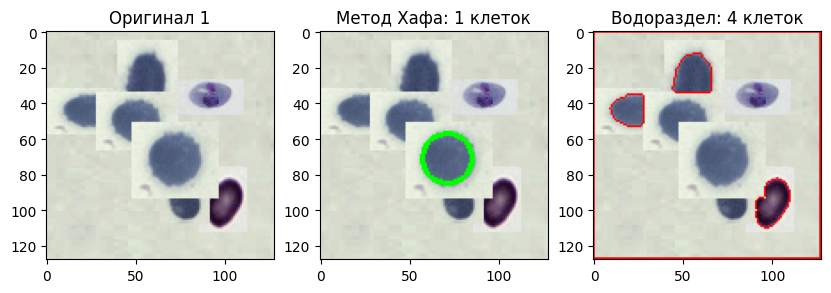

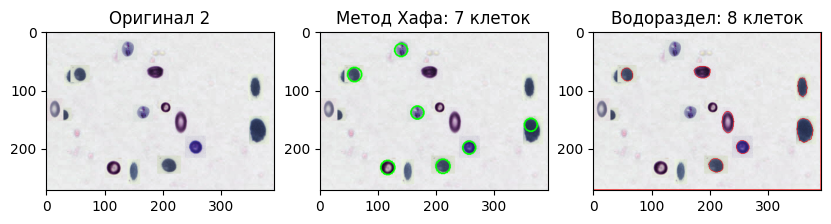

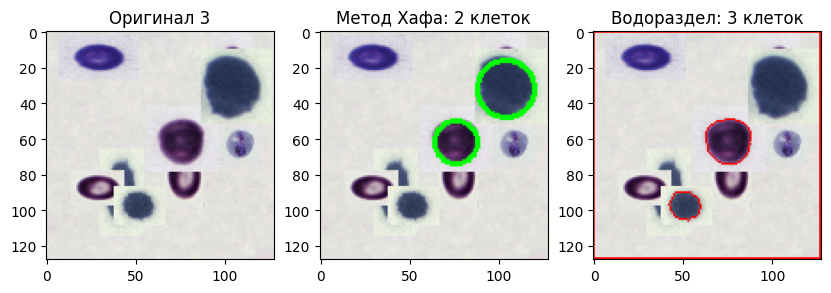

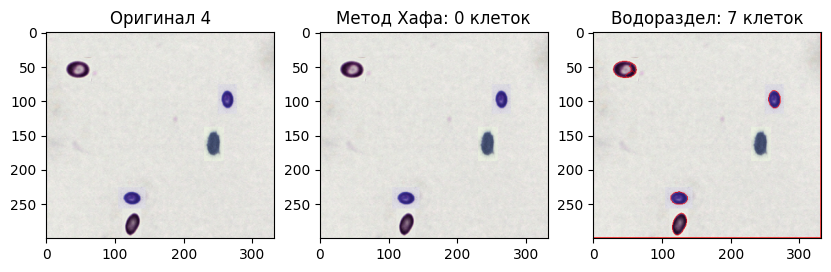

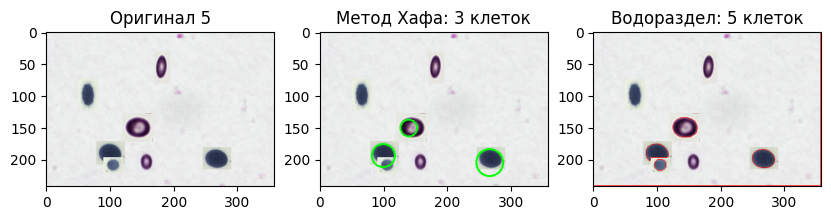

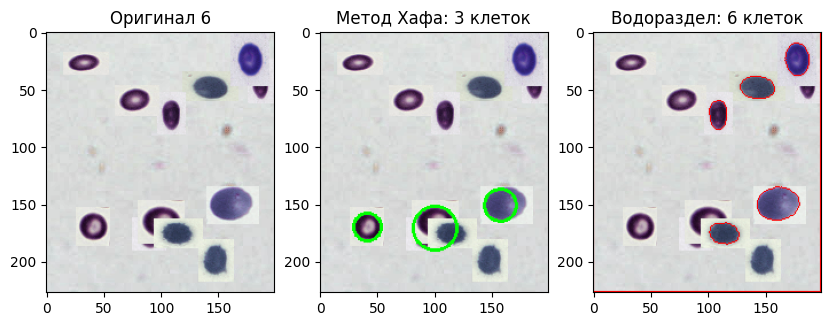

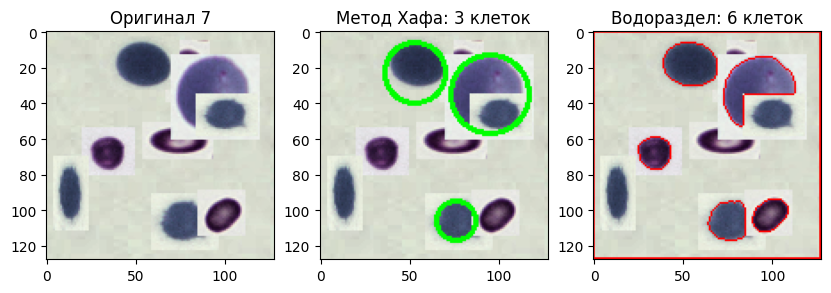

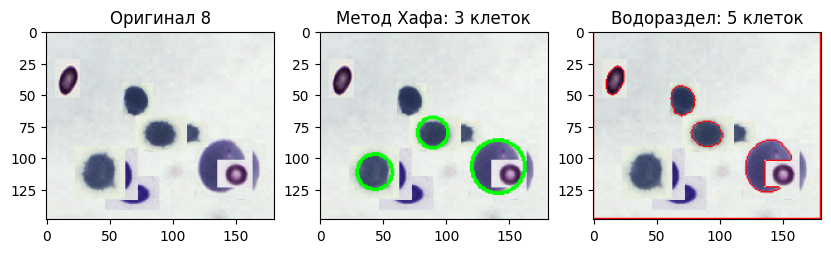

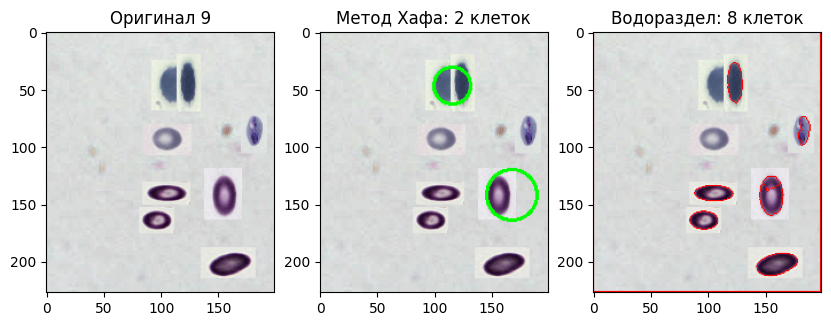

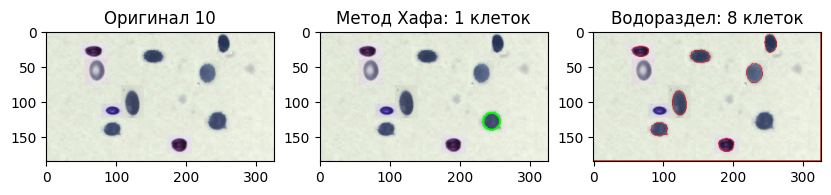

Набор данных – Результаты сегментации:
Метод Хафа: Accuracy=0.2000, Precision=0.3929
Водораздел: Accuracy=0.2000, Precision=0.5000


In [7]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset
import random
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score  
from scipy import ndimage

fon_path = "/Users/zuhroabdulloeva/Desktop/4 КУРС/cv/blood_cells_dataset/fon/"
patch_path = "/Users/zuhroabdulloeva/Desktop/4 КУРС/cv/blood_cells_dataset/patch/"
fon_images = [cv2.imread(os.path.join(fon_path, f)) for f in os.listdir(fon_path) if f.endswith('.png')]
patch_images = [cv2.imread(os.path.join(patch_path, f)) for f in os.listdir(patch_path) if f.endswith('.png')]

# генерация датасета
class BloodCellsDataset(Dataset):
    def __init__(self, mode="generated", dataset_size=10):
        self.mode = mode
        self.dataset_size = dataset_size
        self.images = []

        if mode == "generated":
            self.images = [self._generate_image() for _ in range(dataset_size)]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx]

    def _generate_image(self):
        background = random.choice(fon_images).copy()
        img = background.copy()
        for _ in range(random.randint(5, 15)):
            cell = random.choice(patch_images)
            cell = cv2.resize(cell, (random.randint(20, 50), random.randint(20, 50)))
            x, y = random.randint(0, img.shape[1] - cell.shape[1]), random.randint(0, img.shape[0] - cell.shape[0])
            img[y:y + cell.shape[0], x:x + cell.shape[1]] = cell
        return img

# метод Хафа 
def hough_circle_segmentation(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.medianBlur(gray, 5)
    circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=1.2, minDist=20, param1=50, param2=30, minRadius=10, maxRadius=40)
    output = image.copy()
    count = 0
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            cv2.circle(output, (i[0], i[1]), i[2], (0, 255, 0), 2)
            count += 1
    return output, count

# водораздел + карта расстояний
def watershed_segmentation(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    distance = ndimage.distance_transform_edt(thresh)
    _, markers = cv2.connectedComponents((distance > 0.5 * distance.max()).astype(np.uint8))
    markers = cv2.watershed(image, markers)
    output = image.copy()
    output[markers == -1] = [0, 0, 255]
    return output, np.max(markers)

# оценка качества сегментации
def evaluate_segmentation(true_counts, predicted_counts):
    accuracy = accuracy_score(true_counts, predicted_counts)
    precision = precision_score(true_counts, predicted_counts, average="macro", zero_division=1)  
    return accuracy, precision

def test_segmentation(dataset, method_name):
    true_counts, hough_counts, watershed_counts = [], [], []

    for i, image in enumerate(dataset):
        hough_output, hough_count = hough_circle_segmentation(image)
        watershed_output, watershed_count = watershed_segmentation(image)

        true_counts.append(random.randint(hough_count - 3, hough_count + 3)) 
        hough_counts.append(hough_count)
        watershed_counts.append(watershed_count)

        plt.figure(figsize=(10, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(f"Оригинал {i+1}")

        plt.subplot(1, 3, 2)
        plt.imshow(cv2.cvtColor(hough_output, cv2.COLOR_BGR2RGB))
        plt.title(f"Метод Хафа: {hough_count} клеток")

        plt.subplot(1, 3, 3)
        plt.imshow(cv2.cvtColor(watershed_output, cv2.COLOR_BGR2RGB))
        plt.title(f"Водораздел: {watershed_count} клеток")

        plt.show()

    hough_accuracy, hough_precision = evaluate_segmentation(true_counts, hough_counts)
    watershed_accuracy, watershed_precision = evaluate_segmentation(true_counts, watershed_counts)

    print(f"{method_name} – Результаты сегментации:")
    print(f"Метод Хафа: Accuracy={hough_accuracy:.4f}, Precision={hough_precision:.4f}")
    print(f"Водораздел: Accuracy={watershed_accuracy:.4f}, Precision={watershed_precision:.4f}")

datasets = {
    "Набор данных": BloodCellsDataset(mode="generated", dataset_size=10),
}

for name, dataset in datasets.items():
    test_segmentation(dataset, name)